# Basics

## Imports

In [1]:
import tensorflow as tf
print(f"TF Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TF Version: 2.10.0-dev20220717
GPU Available: True


In [2]:
import os
import datetime
import itertools
import random

random.seed(42)
import warnings

#import backtrader as bt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
from arch import arch_model
from arch.__future__ import reindexing
from matplotlib.ticker import FixedLocator, FixedFormatter
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import optuna
from optuna.trial import TrialState
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             f1_score, mean_squared_error, precision_recall_curve,
                             precision_score, recall_score, silhouette_score)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Concatenate, Dense, Dropout, Embedding, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from tqdm.auto import tqdm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import adfuller, coint, kpss, OLS

In [3]:
from src.database.database_connectivity import DatabaseConnectivity
from src.utilities.helper import pred_color_presentation

warnings.filterwarnings("ignore", category=FutureWarning)
os.environ["OMP_NUM_THREADS"] = "1"  # Set before importing sklearn
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress TensorFlow logs
# logging.set_verbosity(logging.WARNING)

# create an instance of DBconnectivity
db = DatabaseConnectivity()

2025-05-17 09:10:03 : Connection to trading_database successful!


## Setup

In [4]:
# Visualization basics
# %matplotlib inline

fig_path = r'D:\PythonProjects\Trading\src\fig'  


def pred_color_presentation(c):
    custom_palette_presentation = {
        'midnight-blue': '#191970',
        'forest-green': '#228B22',
        'muted-gold': '#B8860B',
        'light-gray': '#D3D3D3',
        'sea-green': '#2E8B57',
        'teal-green': '#008080',
        'highlight': '#C19A6B',
        'red':'#a00000',
        'dark-blue': '#082A54',
        'dark-red': '#E02B35',
        'blue': '#1a80bb',
        'light-blue': '#8CC5E3',
        'black': '#000000',
        'black2': '#333333',
        'black3':'#666666',
        'black4':'#999999',
        'black5':'#CCCCCC',
        'color1':'#dfdfdf',
        'color2':'#dfb834',
        'color3':'#f1f6db',
        'color4':'#649e92',
        'color5':'#a13d61',
    }
    return custom_palette_presentation.get(c, "Invalid color name")

def pred_color(c):
    custom_palette_presentation = {
        'blue':'#1A80BB',
        'orange': '#EA801C',
        'red':'#A00000',
        'black1': '#000000',
        'black2': '#333333',
        'black3':'#666666',
        'black4':'#999999',
        'black5':'#CCCCCC',
        
    }
    return custom_palette_presentation.get(c, "Invalid color name")

# https://www.simplifiedsciencepublishing.com/resources/best-color-palettes-for-scientific-figures-and-data-visualizations

# Load and Prepare Data 

## Data Ingestion

### Sector

In [5]:
query = f"""
SELECT a.symbol, a.timestamp, a.close, y.longname, y.sector, y.industry
FROM yahoo_finance_info_new y, yahoo_data_hour a
WHERE y.symbol = a.symbol;
"""

entire_df = db.fetch_data(query)
print(f"The number of stocks selected for analysis are {len(entire_df['symbol'].unique())}")

The number of stocks selected for analysis are 1067


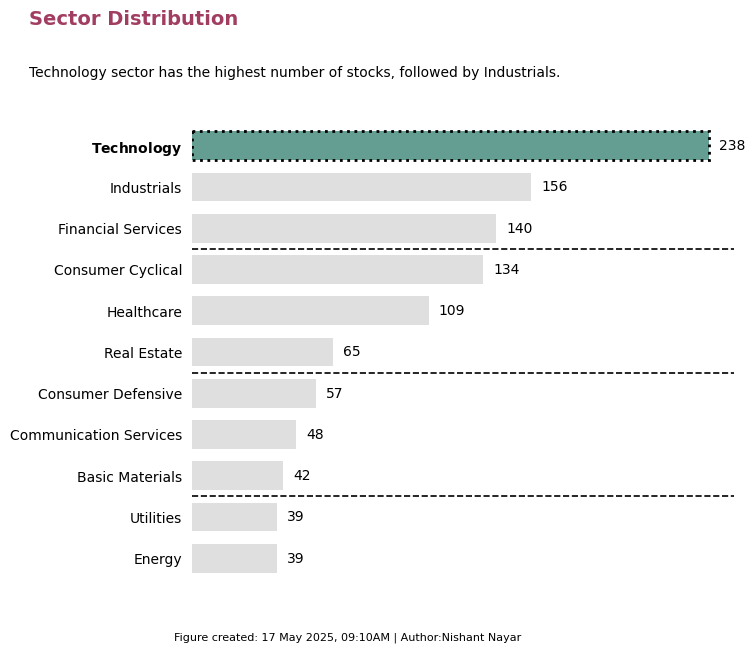

In [6]:
# Get current date and time
now = datetime.datetime.now()
formatted_date_time = now.strftime("%d %b %Y, %I:%M%p") 

# Prepare unique industry counts
temp_df = entire_df[['symbol', 'sector']].drop_duplicates()
sector_counts = temp_df['sector'].value_counts().sort_values(ascending=False)

# Identify the industry with the highest count
max_index = sector_counts.idxmax()

# Define colors based on the highest count
colors = [pred_color_presentation('color1') if sector != max_index else pred_color_presentation('color4') for sector in sector_counts.index]

# Create a horizontal bar chart with highest at the top
ax = sector_counts.plot(kind='barh', figsize=(7, 6), width=0.7, color=colors)

# Reverse the order so the highest value appears at the top
ax.invert_yaxis()

# Keep y-labels but remove y-ticks
ax.set_yticks(range(len(sector_counts)))

# Make y-labels and bold the one for max industry
yticklabels = []
for sector in sector_counts.index:
    if sector == max_index:
        yticklabels.append(f"$\\bf{{{sector}}}$")
    else:
        yticklabels.append(sector)
ax.set_yticklabels(yticklabels, fontsize=10)

ax.tick_params(left=False)

# Add margin space between labels and bars
ax.margins(y=0.1)

# Add horizontal lines to group pairs of three
for i in range(3, len(sector_counts), 3):
    ax.axhline(y=i - 0.5, color='black', linestyle='dashed', linewidth=1.2)

# Customize the chart
ax.set_xlabel('Number of Stocks')
ax.set_ylabel('')
ax.set_xticklabels([])  
ax.xaxis.set_visible(False)  
ax.grid(axis='x', linestyle='none')
ax.grid(axis='y', linestyle='none')

# Remove unnecessary spines
for spine in ['right', 'top', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# Get bar positions for count labels
bar_containers = ax.containers  
bar_y_positions = [rect.get_y() + rect.get_height() / 2 for rect in bar_containers[0]]

# Add count labels with bold for the highest count
for count, y_pos, industry in zip(sector_counts, bar_y_positions, sector_counts.index):
    fontweight = 'bold' if sector == max_index else 'normal'
    ax.text(
        count + max(sector_counts) * 0.02,
        y_pos,
        str(count),
        va='center',
        ha='left',
        fontsize=10,
        fontweight=fontweight
    )

# Add a dotted border around the bar with the highest count
for rect, sector in zip(bar_containers[0], sector_counts.index):
    if sector == max_index:
        x = rect.get_x()
        y = rect.get_y()
        width = rect.get_width()
        height = rect.get_height()

        dotted_rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor='black',
            facecolor='none',
            linestyle='dotted'
        )
        ax.add_patch(dotted_rect)
        break

# Add annotation for the highest industry
plt.annotate(
    'Sector Distribution', 
    xy=(-0.3, 1.2), 
    xycoords='axes fraction', 
    fontsize=14, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color_presentation('color5')
)

plt.annotate(
    f'{sector_counts.index[0]} sector has the highest number of stocks, followed by {sector_counts.index[1]}.', 
    xy=(-0.3, 1.09), 
    xycoords='axes fraction', 
    fontsize=10, 
    ha='left', 
    va='bottom',
    color='black'
)

# Add footnote with date and time
plt.figtext(
    0.1,  
    0.01,  
    f"Figure created: {formatted_date_time} | Author:Nishant Nayar",
    horizontalalignment='left',
    verticalalignment='bottom',
    fontsize=8,
    color='black'
)

# Save and show the plot
fig_name = f'industry_distribution_{sector}.jpg'
# plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

### Technology

In [7]:
sector = 'Technology'

query = f"""
SELECT a.symbol, a.timestamp, a.close, y.longname, y.sector, y.industry
FROM yahoo_finance_info_new y, yahoo_data_hour a
WHERE y.symbol = a.symbol
AND y.sector = '{sector}';
"""

original_df = db.fetch_data(query)
print(f"The number of stocks selected for analysis are {len(original_df['symbol'].unique())}")

# format sector after running query to use in code
sector = sector.lower().replace(' ', '_')

The number of stocks selected for analysis are 238


## Gaps

In [8]:
symbol_counts = pd.DataFrame(original_df['symbol'].value_counts())
high = symbol_counts['count'].head(1).values
low = symbol_counts['count'].tail(1).values
if high[0] == low[0]:
    print('The values match, no need to perform any cleaning activity.')
else:
    print('The values do not match')

The values do not match


In [9]:
# Calculate 70% of the highest count
high_percent = high[0] * 0.80

# Filter symbols
filtered_symbols = symbol_counts[symbol_counts['count']> 1800]

# Get the symbols from filtered_symbols
filtered_symbol_list = filtered_symbols.index
# Filter result_df based on the selected symbols
original_df = original_df[original_df['symbol'].isin(filtered_symbol_list)]

In [10]:
print(f"The number of stocks selected for analysis are {len(original_df['symbol'].unique())}")

The number of stocks selected for analysis are 234


In [11]:
# 1. Get the highest count
highest_count = original_df['timestamp'].value_counts().max()

# 2. Get the timestamps that have this highest count (handles ties)
most_common_timestamps = original_df['timestamp'].value_counts()[original_df['timestamp'].value_counts() == highest_count].index.tolist()

# 3. Filter the DataFrame
original_df = original_df[original_df['timestamp'].isin(most_common_timestamps)]

print(f"The number of unique stocks remaining are {len(original_df['symbol'].unique())}")

The number of unique stocks remaining are 234


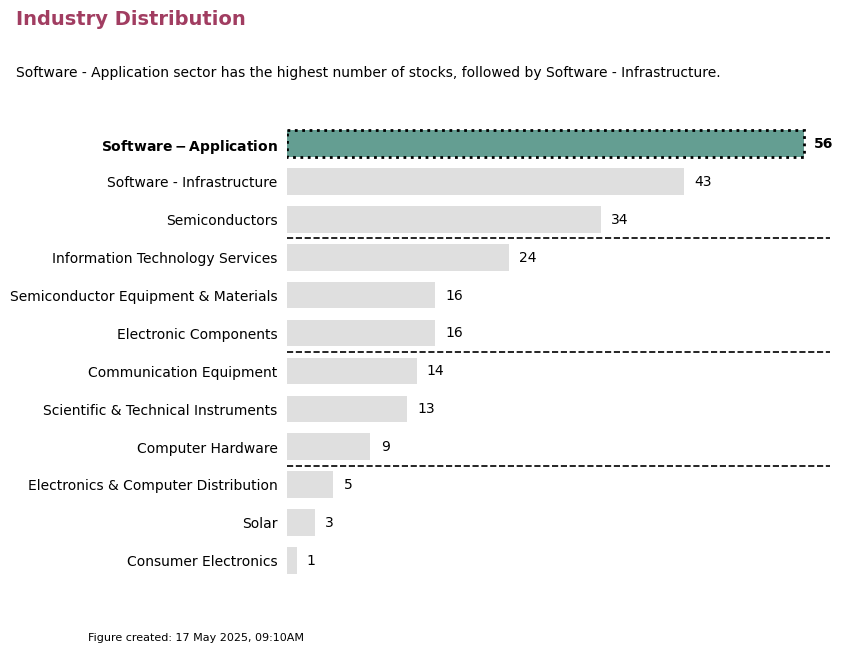

In [12]:
# Get current date and time
now = datetime.datetime.now()
formatted_date_time = now.strftime("%d %b %Y, %I:%M%p") 

# Prepare unique industry counts
temp_df = original_df[['symbol', 'industry']].drop_duplicates()
industry_counts = temp_df['industry'].value_counts().sort_values(ascending=False)

# Identify the industry with the highest count
max_index = industry_counts.idxmax()

# Define colors based on the highest count
colors = [pred_color_presentation('color1') if industry != max_index else pred_color_presentation('color4') for industry in industry_counts.index]

# Create a horizontal bar chart with highest at the top
ax = industry_counts.plot(kind='barh', figsize=(7, 6), width=0.7, color=colors)

# Reverse the order so the highest value appears at the top
ax.invert_yaxis()

# Keep y-labels but remove y-ticks
ax.set_yticks(range(len(industry_counts)))

# Make y-labels and bold the one for max industry
yticklabels = []
for industry in industry_counts.index:
    if industry == max_index:
        yticklabels.append(f"$\\bf{{{industry}}}$")
    else:
        yticklabels.append(industry)
ax.set_yticklabels(yticklabels, fontsize=10)

ax.tick_params(left=False)

# Add margin space between labels and bars
ax.margins(y=0.1)

# Add horizontal lines to group pairs of three
for i in range(3, len(industry_counts), 3):
    ax.axhline(y=i - 0.5, color='black', linestyle='dashed', linewidth=1.2)

# Customize the chart
ax.set_xlabel('Number of Stocks')
ax.set_ylabel('')
ax.set_xticklabels([])  
ax.xaxis.set_visible(False)  
ax.grid(axis='x', linestyle='none')
ax.grid(axis='y', linestyle='none')

# Remove unnecessary spines
for spine in ['right', 'top', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# Get bar positions for count labels
bar_containers = ax.containers  
bar_y_positions = [rect.get_y() + rect.get_height() / 2 for rect in bar_containers[0]]

# Add count labels with bold for the highest count
for count, y_pos, industry in zip(industry_counts, bar_y_positions, industry_counts.index):
    fontweight = 'bold' if industry == max_index else 'normal'
    ax.text(
        count + max(industry_counts) * 0.02,
        y_pos,
        str(count),
        va='center',
        ha='left',
        fontsize=10,
        fontweight=fontweight
    )

# Add a dotted border around the bar with the highest count
for rect, industry in zip(bar_containers[0], industry_counts.index):
    if industry == max_index:
        x = rect.get_x()
        y = rect.get_y()
        width = rect.get_width()
        height = rect.get_height()

        dotted_rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor='black',
            facecolor='none',
            linestyle='dotted'
        )
        ax.add_patch(dotted_rect)
        break

# Add annotation for the highest industry
plt.annotate(
    'Industry Distribution', 
    xy=(-0.5, 1.2), 
    xycoords='axes fraction', 
    fontsize=14, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color_presentation('color5')
)

plt.annotate(
    f'{industry_counts.index[0]} sector has the highest number of stocks, followed by {industry_counts.index[1]}.', 
    xy=(-0.5, 1.09), 
    xycoords='axes fraction', 
    fontsize=10, 
    ha='left', 
    va='bottom',
    color='black'
)

# Add footnote with date and time
plt.figtext(
    -0.16,  
    0.01,  
    f"Figure created: {formatted_date_time}",
    horizontalalignment='left',
    verticalalignment='bottom',
    fontsize=8,
    color='black'
)

# Save and show the plot
fig_name = f'industry_distribution_{sector}.jpg'
# plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

# GRU Method

## Data Preparation & Preprocessing

### Normalize

Use logarithmic returns or z-scores to stabilize variance.

**Log Close vs. Log of Returns**

**Log Close**

- This is simply the natural logarithm of the closing price: $log(P_t)$
- Used primarily in cointegration testing and spread construction.

**Log Returns**

- This is the difference in log closing prices between consecutive time periods: $$r_t = log(P_t) - log(P_t-1) = log(\frac{P_t} {P_t-1})$$
- Log returns are used for **modeling price changes**, volatility, and returns distributions.
- **Variance is more stable** for log returns compared to raw prices.

**Z-Score Normalization - Expanding Window**

**Which To Use Where?**

- Cointegration & Spread Construction:
    - Use **log close prices** (not returns). Spread is typically based on logs of prices, e.g., 
    - This is because cointegration is about finding stationary combinations of non-stationary price series.
                - $$Spread_t = log(P_A,t) - \beta log(P_B,t) - \mu$$
    

- Volatility Modeling (GARCH), Time-Series Features, etc.:
    - Use **log returns** as input for volatility estimation and normalization.
- Normalization / Z-scores:
    - If you're normalizing the spread, use z-scores **of the spread series** (which itself is constructed from log prices).
    - If you’re normalizing returns, use z-scores **of log returns**.  

| **Task**              | **Use**                           | **Why**                               |
|-----------------------|-----------------------------------|---------------------------------------|
| Cointegration tests   | log close                         | To assess long-term relationship      |
| Spread construction   | log close                         | To build mean-reverting spread        |
| Volatility modeling   | log returns                       | To stabilize variance                 |
| Z-score normalization | log close (spread) or log returns | Depending on what is being normalized |

In [13]:
# Step 1: Create a copy of the dataframe
gru_result_df = original_df.copy()

# Step 2: Create the log_close column by applying log transformation within the group
gru_result_df['log_close'] = gru_result_df.groupby('symbol')['close'].transform(lambda x: np.log(x))

gru_result_df['log_return'] = gru_result_df.groupby('symbol')['log_close'].diff()
gru_result_df['z_scores'] = gru_result_df.groupby('symbol')['log_return'].transform(
    lambda x: (x - x.expanding().mean()) / x.expanding().std()
)

# Remove rows with NaN in 'log_return'
gru_result_df = gru_result_df.dropna(subset=['log_return'])
gru_result_df = gru_result_df.dropna(subset=['z_scores'])

# Reset Index
gru_result_df = gru_result_df.reset_index(drop=True)

### Statistical Tests for Variance Stability

|Method| 	Successful Stabilization Sign                                    |
|---|-------------------------------------------------------------------|
|Visual Plot|No obvious "funnel" shape (e.g., widening/narrowing volatility).  |
|Rolling Std|Flat or stable trend (no large spikes/dips).                     |
|ARCH Test|p-value > 0.05 → Residual heteroscedasticity is not significant.   |

#### Visual Inspection

- **Time Series Plot**
    - Plot the original series vs. the transformed series.
    - Look for reduction in “clustering” of high and low variance.
    - **Interpretation** : Log returns should look more “stationary” (consistent variance) compared to raw prices.

In [14]:
asset_1 = 'AAPL'
stat_test_df = gru_result_df[gru_result_df['symbol'] ==asset_1]
stat_test_df.head(5)

,symbol,timestamp,close,longname,sector,industry,log_close,log_return,z_scores
0,AAPL,2024-04-01 10:30:00-05:00,169.8950,Apple Inc.,Technology,Consumer Electronics,5.135181,0.000294,0.707107
1,AAPL,2024-04-01 11:30:00-05:00,169.9157,Apple Inc.,Technology,Consumer Electronics,5.135302,0.000122,0.484763
2,AAPL,2024-04-01 12:30:00-05:00,169.9950,Apple Inc.,Technology,Consumer Electronics,5.135769,0.000467,0.689629
3,AAPL,2024-04-01 13:30:00-05:00,169.9350,Apple Inc.,Technology,Consumer Electronics,5.135416,-0.000353,-0.222641
4,AAPL,2024-04-01 14:30:00-05:00,170.0100,Apple Inc.,Technology,Consumer Electronics,5.135857,0.000441,0.709953


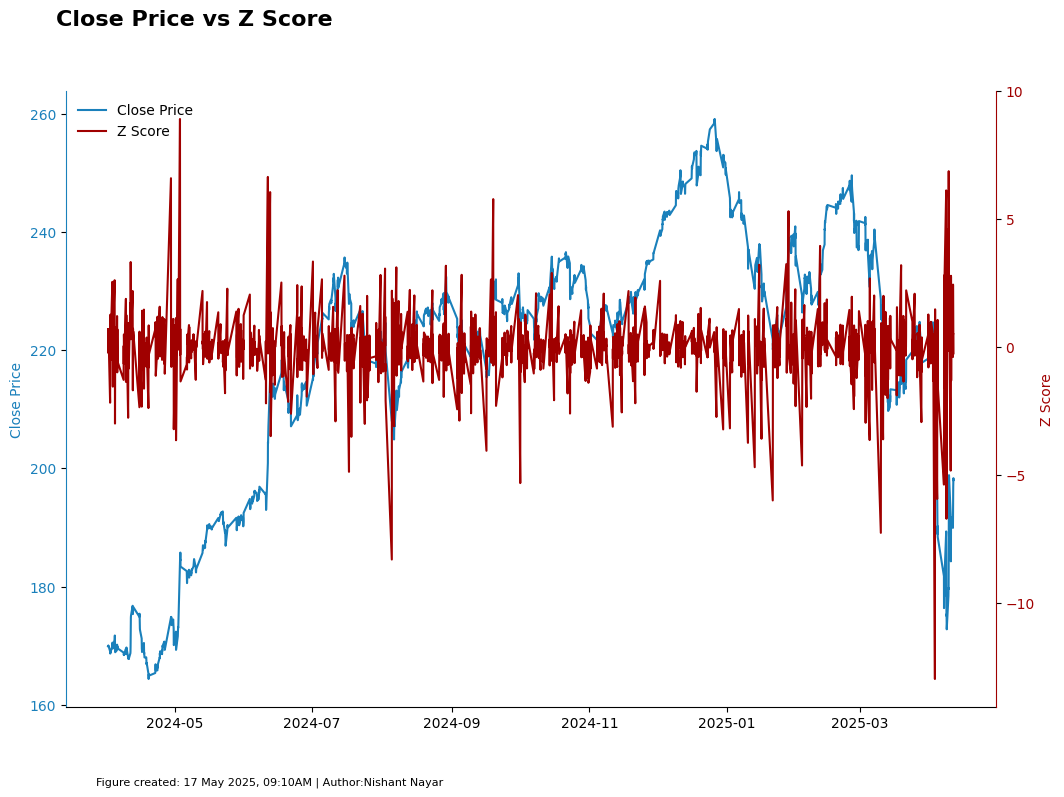

In [15]:
# Get current date and time
now = datetime.datetime.now()
formatted_date_time = now.strftime("%d %b %Y, %I:%M%p") 

fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot log_close on the primary y-axis
ax1.plot(stat_test_df.timestamp, stat_test_df.close, color=pred_color('blue'), 
         label='Close Price')
ax1.set_ylabel('Close Price', color=pred_color('blue'))
ax1.tick_params(axis='y', labelcolor=pred_color('blue'))
# Remove all spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(pred_color('blue'))  # Removed left spine
#ax1.spines['bottom'].set_visible(False)  # Removed bottom spine
# Hide grid lines
ax1.grid(False)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(stat_test_df.timestamp, stat_test_df.z_scores, color=pred_color('red'), 
         label='Z Score')
ax2.set_ylabel('Z Score', color=pred_color('red'))
ax2.tick_params(axis='y', labelcolor=pred_color('red'))
# Remove all spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color(pred_color('red'))
ax2.spines['left'].set_visible(False)  # Removed left spine
ax2.spines['bottom'].set_visible(False)  # Removed bottom spine
# Hide grid lines
ax2.grid(False)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', frameon=False)

# plt.title("Close Price vs Z Score")
plt.annotate(
    'Close Price vs Z Score', 
    xy=(-0.01, 1.1), 
    xycoords='axes fraction', 
    fontsize=16, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color('black1')
)



# Add footnote with date and time
plt.figtext(
    0.15,  
    0.01,  
    f"Figure created: {formatted_date_time} | Author:Nishant Nayar",
    horizontalalignment='left',
    verticalalignment='bottom',
    fontsize=8,
    color='black'
)

plt.show()

#### Rolling Standard Deviation

- Calculate a rolling standard deviation before and after transformation.
- Consistent rolling std indicates more stable variance.

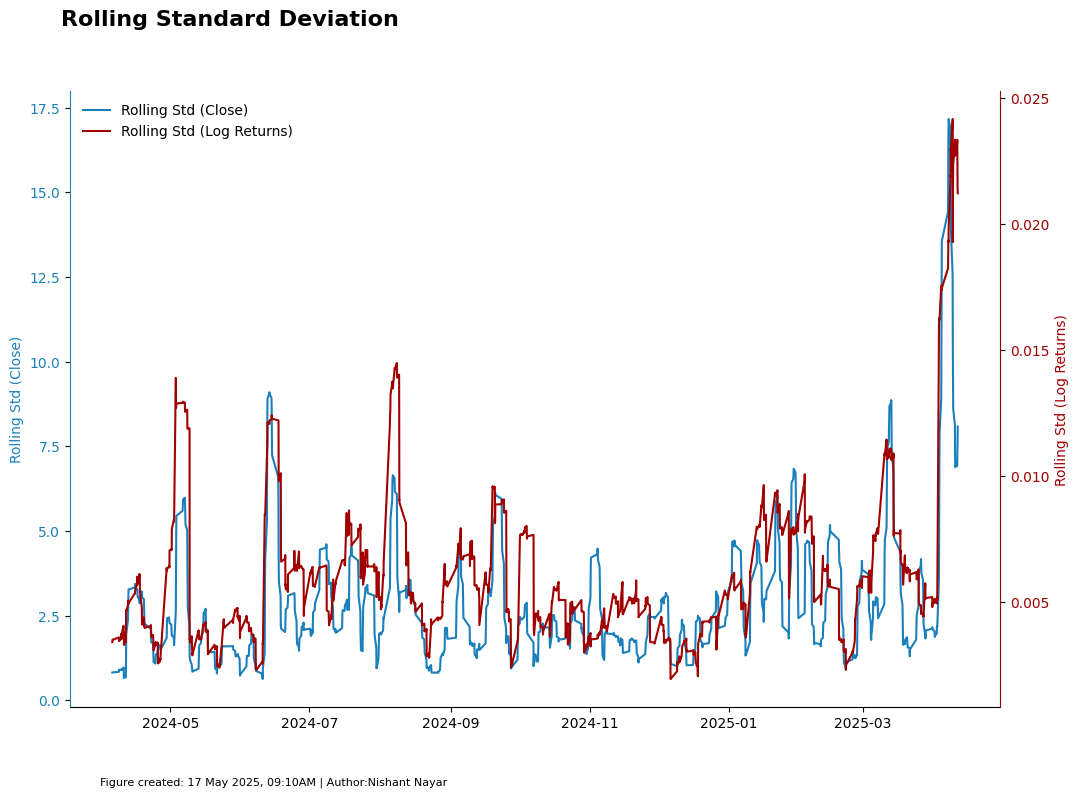

In [16]:
window = 30
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot log_close on the primary y-axis
ax1.plot(stat_test_df.timestamp, stat_test_df.close.rolling(window).std(), 
         color=pred_color('blue'), 
         label='Rolling Std (Close)')
ax1.set_ylabel('Rolling Std (Close)', color=pred_color('blue'))
ax1.tick_params(axis='y', labelcolor=pred_color('blue'))
# Remove all spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(pred_color('blue'))  

# Hide grid lines
ax1.grid(False)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(stat_test_df.timestamp, stat_test_df.log_return.rolling(window).std(), 
         color=pred_color('red'), 
         label='Rolling Std (Log Returns)')
ax2.set_ylabel('Rolling Std (Log Returns)', color=pred_color('red'))
ax2.tick_params(axis='y', labelcolor=pred_color('red'))
# Remove all spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color(pred_color('red'))
ax2.spines['left'].set_visible(False)  # Removed left spine
ax2.spines['bottom'].set_visible(False)  # Removed bottom spine
# Hide grid lines
ax2.grid(False)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, 
           loc='upper left',
           frameon=False)

#plt.title("Rolling Standard Deviation")

# plt.title("Close Price vs Z Score")
plt.annotate(
    'Rolling Standard Deviation', 
    xy=(-0.01, 1.1), 
    xycoords='axes fraction', 
    fontsize=16, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color('black1')
)

# Add footnote with date and time
plt.figtext(
    0.15,  
    0.01,  
    f"Figure created: {formatted_date_time} | Author:Nishant Nayar",
    horizontalalignment='left',
    verticalalignment='bottom',
    fontsize=8,
    color='black'
)

plt.show()

#### ARCH Test (for heteroscedasticity)

- The ARCH LM Test checks for residual heteroscedasticity.
- Lower test statistic or higher p-value after transformation implies better variance stabilization

In [17]:
arch_test_stat, arch_pvalue, *_ = het_arch(stat_test_df.log_return, nlags=5)
print(f"ARCH Test p-value: {arch_pvalue:.4f}")  # Want p > 0.05
if arch_pvalue > 0.05:
    print('Residual heteroscedasticity is not significant.')
else:
    print('Residual heteroscedasticity is significant.')

ARCH Test p-value: 0.0057
Residual heteroscedasticity is significant.


In [18]:
arch_test_stat, arch_pvalue, *_ = het_arch(stat_test_df.z_scores, nlags=5)
print(f"ARCH Test p-value: {arch_pvalue:.4f}")  # Want p > 0.05
if arch_pvalue > 0.05:
    print('Residual heteroscedasticity is not significant.')
else:
    print('Residual heteroscedasticity is significant.')

ARCH Test p-value: 0.1131
Residual heteroscedasticity is not significant.


In [19]:
# Initialize results DataFrame
heteroscedasticity_df = pd.DataFrame(columns=['symbol', 'Significant'])

# Get unique symbols
symbols = gru_result_df['symbol'].unique()

# Test each symbol for ARCH effects
for symbol in tqdm(symbols, desc='Testing for Heteroscedasticity', unit='symbol'):
    # Filter data for current symbol
    symbol_data = gru_result_df[gru_result_df['symbol'] == symbol]
    
    # Perform ARCH test (using z_scores)
    _, pvalue, *_ = het_arch(symbol_data['z_scores'].dropna(), nlags=5)
    
    # Determine significance
    significant = 'No' if pvalue > 0.05 else 'Yes'
    
    # Append results (more efficient than concat in loop)
    heteroscedasticity_df.loc[len(heteroscedasticity_df)] = [symbol, significant]

Testing for Heteroscedasticity:   0%|          | 0/234 [00:00<?, ?symbol/s]

In [20]:
heteroscedasticity_df['Significant'].value_counts()

Significant
No     193
Yes     41
Name: count, dtype: int64

In [21]:
# Remove symbols that do not pass test for heteroscedasticity
out_of_scope = heteroscedasticity_df['symbol'][heteroscedasticity_df['Significant']=='Yes']
filtered_gru_result_df = gru_result_df[~gru_result_df['symbol'].isin(out_of_scope)]

## Initial Pair Screening

### Correlation Analysis

Shortlist pairs with high correlation (e.g., Pearson’s ρ > 0.8)

In [22]:
# Get unique symbols from filtered data
symbols = filtered_gru_result_df['symbol'].unique()

# Generate all possible pairs
symbol_pairs = list(itertools.combinations(symbols, 2))

# Convert to DataFrame
pairs_df = pd.DataFrame(symbol_pairs, columns=['Symbol_1', 'Symbol_2'])

print(f"Generated {len(pairs_df)} total possible pairs from {len(symbols)} symbols")

Generated 18528 total possible pairs from 193 symbols


In [23]:
filtered_gru_result_df.columns

Index(['symbol', 'timestamp', 'close', 'longname', 'sector', 'industry',
       'log_close', 'log_return', 'z_scores'],
      dtype='object')

In [24]:
# Initialize an empty list to store the correlation values
correlations = []

# Pivot the data once for faster access
pivoted_data = filtered_gru_result_df.pivot(index='timestamp', columns='symbol', values='log_close')

# Loop through the symbol pairs and compute the correlation for each pair
for symbol_1, symbol_2 in tqdm(symbol_pairs, desc='Generating correlations', unit='pairs'):
    # Use the pivoted data for vectorized correlation calculation
    corr_value = pivoted_data[symbol_1].corr(pivoted_data[symbol_2])
    if not pd.isna(corr_value):  # Only append if correlation is valid
        correlations.append([symbol_1, symbol_2, corr_value])

limit = 0.8

# Convert the correlations list into a DataFrame
correlation_df = pd.DataFrame(correlations, columns=['Symbol_1', 'Symbol_2', 'Correlation'])
correlation_df_filtered = correlation_df[correlation_df['Correlation'] > limit].sort_values(by='Correlation', ascending=False)
print(f"There are {len(correlation_df_filtered)} pairs above {limit}")

Generating correlations:   0%|          | 0/18528 [00:00<?, ?pairs/s]

There are 1460 pairs above 0.8


In [25]:
correlation_df_filtered.head(5)

,Symbol_1,Symbol_2,Correlation
558,ACLS,VECO,0.979335
1261,ADP,PAYX,0.977476
1200,ADP,FI,0.975230
8109,CSCO,FI,0.972010
10909,FFIV,FTNT,0.970048


### Cointegration Test

Apply the Engle-Granger test to identify pairs with a stable long-term relationship (e.g., p-value < 0.05).

In [26]:
final_results_df = correlation_df_filtered.copy()

In [27]:
final_results_df['cointegration'] = None

# Loop through each row in final_results_df with tqdm progress bar
for idx, row in tqdm(final_results_df.iterrows(), total=len(final_results_df), 
                     desc = 'Calculating cointegration',
                     unit='rows'):
    symbol1 = row['Symbol_1']
    symbol2 = row['Symbol_2']
    
    # Engle-Granger cointegration test
    try:
        _, pvalue, _ = coint(pivoted_data[symbol_1], pivoted_data[symbol_2])
        final_results_df.at[idx, 'cointegration'] = pvalue
    except Exception as e:
        print(f"Error calculating beta for {symbol1} ~ {symbol2}: {e}")
        final_results_df.at[idx, 'cointegration'] = None   

Calculating cointegration:   0%|          | 0/1460 [00:00<?, ?rows/s]

In [28]:
final_results_df['cointegration'] = np.nan  # Initialize with NaN instead of None for better pandas handling

# Loop through each row in final_results_df with tqdm progress bar
for idx, row in tqdm(final_results_df.iterrows(), total=len(final_results_df), 
                     desc='Calculating cointegration',
                     unit='rows'):
    symbol1 = row['Symbol_1']
    symbol2 = row['Symbol_2']
    
    # Engle-Granger cointegration test
    try:
        # Get the price series for both symbols (with error handling)
        series1 = pivoted_data.get(symbol1, pd.Series(dtype=float))
        series2 = pivoted_data.get(symbol2, pd.Series(dtype=float))
        
        # Align and clean the data
        aligned = pd.concat([series1, series2], axis=1).dropna()
        if len(aligned) < 30:  # Minimum data points required
            continue
            
        _, pvalue, _ = coint(aligned.iloc[:,0], aligned.iloc[:,1])
        final_results_df.at[idx, 'cointegration'] = pvalue
    except Exception as e:
        # Print more specific error information
        print(f"Error calculating cointegration for {symbol1} ~ {symbol2}: {str(e)[:100]}")
        continue

# Add a column indicating significant cointegration
final_results_df['is_significant'] = final_results_df['cointegration'] < 0.05

print(f"Testing complete. Significant pairs found: {final_results_df['is_significant'].sum()}")

Calculating cointegration:   0%|          | 0/1460 [00:00<?, ?rows/s]

Testing complete. Significant pairs found: 267


In [29]:
# Filter for significant pairs and sort by p-value (most significant first)
significant_pairs = final_results_df[
    final_results_df['is_significant'] == True
].sort_values('cointegration', ascending=True)  # Changed to ascending=True to show lowest p-values first

# Display the results
print(f"Found {len(significant_pairs)} significantly cointegrated pairs:")

Found 267 significantly cointegrated pairs:


In [30]:
significant_pairs.head(5)

,Symbol_1,Symbol_2,Correlation,cointegration,is_significant
16829,PDFS,ROG,0.965451,0.000095,True
5269,BR,PLTR,0.949769,0.000136,True
16672,PAYX,TDY,0.951796,0.000176,True
11085,FI,PAYX,0.967839,0.000186,True
18214,TDY,VIAV,0.947231,0.000269,True


## Spread Construction

For each pair calculate the spread

$$Spread_t = log (P_1,t) - \beta log (P_2,t) - \mu$$

where β is the cointegration coefficient (OLS regression slope)

In [31]:
# Initialize a column to store spreads
significant_pairs['spread'] = None

# Calculate spread for each significant pair
for idx, row in tqdm(significant_pairs.iterrows(),
                        total=len(significant_pairs),
                     desc='Calculating Spreads', unit='row'):
    symbol1 = row['Symbol_1']
    symbol2 = row['Symbol_2']
    
    # Get aligned log_close series (no need for np.log again)
    aligned = pd.concat([pivoted_data[symbol1], pivoted_data[symbol2]], axis=1).dropna()
    log_p1 = aligned.iloc[:, 0]  # Already log_close
    log_p2 = aligned.iloc[:, 1]  # Already log_close
    
    # Calculate β (cointegration coefficient) via OLS
    X = sm.add_constant(log_p2)  # Add constant for intercept
    model = sm.OLS(log_p1, X).fit()
    beta = model.params[1]  # Slope coefficient
    mu = model.params[0]    # Intercept
    
    # Calculate spread
    spread = log_p1 - beta * log_p2 - mu
    
    # Store results
    significant_pairs.at[idx, 'beta'] = beta
    significant_pairs.at[idx, 'mu'] = mu
    significant_pairs.at[idx, 'spread'] = spread.tolist()  # Store as list of values

Calculating Spreads:   0%|          | 0/267 [00:00<?, ?row/s]

## GARCH Volatility Modeling

### Retrieve Spread Data

In [32]:
# Convert timestamps to UTC
timestamps = pd.to_datetime(filtered_gru_result_df['timestamp'], utc=True).unique()

# Create Series with UTC timestamps
spread = pd.Series(significant_pairs.iloc[0]['spread'], 
                  index=timestamps[:len(significant_pairs.iloc[0]['spread'])])

### Calculate Log Returns

In [33]:
# For log returns of spread (if spread is already log-transformed):
spread_returns = spread.diff().dropna()  # Simple differences

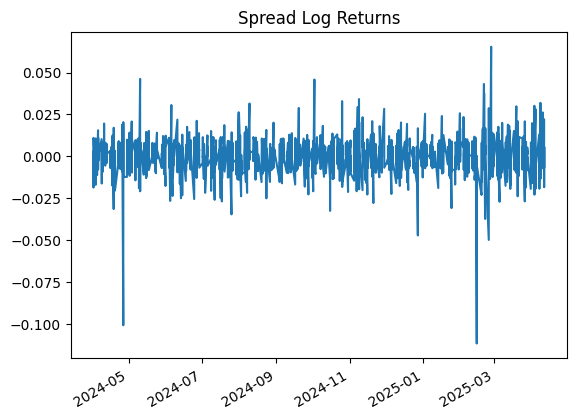

In [34]:
# Visualize
spread_returns.plot(title='Spread Log Returns')
plt.show()

### Fit GARCH Model 

In [35]:
# Rescale returns 
scaling_factor = 1/spread_returns.std()
scaled_returns = spread_returns * scaling_factor

# Fit GARCH model on rescaled data
garch_model = arch_model(scaled_returns, vol='Garch', p=1, q=1)
results = garch_model.fit(update_freq=5, disp='off')

print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2526.33
Distribution:                  Normal   AIC:                           5060.67
Method:            Maximum Likelihood   BIC:                           5082.64
                                        No. Observations:                 1794
Date:                Sat, May 17 2025   Df Residuals:                     1793
Time:                        09:13:52   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         5.4403e-03  2.277e-02      0.239      0.811 

### Analyze Results

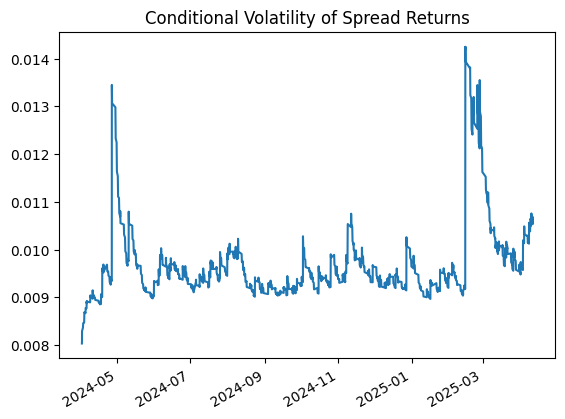

In [36]:
# Remember to rescale back when interpreting results:
conditional_vol = results.conditional_volatility / scaling_factor

# Plot volatility
pd.Series(conditional_vol, index=spread_returns.index).plot(
    title='Conditional Volatility of Spread Returns')
plt.show()

In [37]:
# Check model residuals
residuals = results.resid
standardized_residuals = residuals / conditional_vol

### Diagnostic Test

#### Ljung-Box Test

Check if standardized residuals are serially correlated:

In [38]:
# Perform Ljung-Box test on standardized residuals
lb_test = acorr_ljungbox(standardized_residuals, lags=10, return_df=True)

# Print full test results
print("Ljung-Box Test Results (Autocorrelation in Residuals):")
print(f"Test Statistic: {lb_test.lb_stat.tolist()}")
print(f"P-values: {lb_test.lb_pvalue.tolist()}\n")

Ljung-Box Test Results (Autocorrelation in Residuals):
Test Statistic: [0.5316446785468526, 0.5336984793299261, 0.5375744376373806, 1.0533113073218592, 2.2252082558491226, 3.405258826768918, 7.481405471331628, 9.77784414507665, 10.014916836775484, 10.897152735899775]
P-values: [0.46591622210451944, 0.7657885132959626, 0.9105622364453886, 0.9016073555247837, 0.817186555114402, 0.7565289402121254, 0.3805313291433116, 0.28096591748434485, 0.34927895836935174, 0.365586748792321]



In [39]:
# Check significance at each lag
print("Significant Autocorrelation Present?")
for lag, pval in enumerate(lb_test.lb_pvalue, 1):
    print(f"Lag {lag}: {'No' if pval > 0.05 else 'Yes'} (p = {pval:.4f})")

Significant Autocorrelation Present?
Lag 1: No (p = 0.4659)
Lag 2: No (p = 0.7658)
Lag 3: No (p = 0.9106)
Lag 4: No (p = 0.9016)
Lag 5: No (p = 0.8172)
Lag 6: No (p = 0.7565)
Lag 7: No (p = 0.3805)
Lag 8: No (p = 0.2810)
Lag 9: No (p = 0.3493)
Lag 10: No (p = 0.3656)


In [40]:
# Overall interpretation
if all(p > 0.05 for p in lb_test.lb_pvalue):
    print("\nConclusion: No significant autocorrelation found at any lag (residuals appear white noise)")
else:
    print("\nConclusion: Significant autocorrelation detected (model may be misspecified)")


Conclusion: No significant autocorrelation found at any lag (residuals appear white noise)


#### ARCH Test

Verify no residual heteroscedasticity remains:

In [41]:
# Perform ARCH test on standardized residuals
test_statistic, p_value, *_ = het_arch(standardized_residuals, nlags=5)

# Print full test results
print(f"ARCH-LM Test Results:\n"
      f"Test Statistic: {test_statistic:.4f}\n"
      f"P-value: {p_value:.4f}\n"
      f"Lags: 5")

# Simplified interpretation
print("\nResidual Heteroscedasticity Present?\n")
if p_value > 0.05:
    print("No (p > 0.05, residuals appear homoscedastic)")
else:
    print("Yes (p ≤ 0.05, significant ARCH effects)")

ARCH-LM Test Results:
Test Statistic: 0.5530
P-value: 0.9901
Lags: 5

Residual Heteroscedasticity Present?

No (p > 0.05, residuals appear homoscedastic)


## Hybrid GRU Model

### Single Pair

#### Feature Engineering

GARCH volatility and residuals with other features

In [42]:
# Step 1: Calculate Spread

pair = significant_pairs.iloc[0]  # Example for first pair
symbol1, symbol2 = pair['Symbol_1'], pair['Symbol_2']
beta, mu = pair['beta'], pair['mu']

# Calculate spread
spread = (pivoted_data[symbol1] - beta * pivoted_data[symbol2] - mu).dropna()

In [43]:
# Step 2: Create Lagged Spread Features
if isinstance(spread, pd.Series):
    spread = spread.to_frame(name='spread')

# Now create lagged features
for lag in range(1, 6):
    spread[f'lag_{lag}'] = spread['spread'].shift(lag)

# Drop rows with NaN (from lagging)
spread = spread.dropna()

In [44]:
# Verify the result
spread.head(5)

,spread,lag_1,lag_2,lag_3,lag_4,lag_5
timestamp,,,,,,
2024-04-02 08:30:00-05:00,-0.022545,-0.014158,-0.025156,-0.006524,-0.009516,-0.004970
2024-04-02 09:30:00-05:00,-0.027683,-0.022545,-0.014158,-0.025156,-0.006524,-0.009516
2024-04-02 10:30:00-05:00,-0.023407,-0.027683,-0.022545,-0.014158,-0.025156,-0.006524
2024-04-02 11:30:00-05:00,-0.019202,-0.023407,-0.027683,-0.022545,-0.014158,-0.025156
2024-04-02 12:30:00-05:00,-0.014251,-0.019202,-0.023407,-0.027683,-0.022545,-0.014158


In [45]:
# Step 3: Add GARCH Features
garch_vol = results.conditional_volatility
garch_resid = results.resid / garch_vol

# 4. Align with original spread data
# First create a temporary DataFrame with GARCH outputs
garch_features = pd.DataFrame({
    'garch_vol': garch_vol,
    'garch_resid': garch_resid
}, index=scaled_returns.index)  # Important: use scaled_returns' index

# 5. Merge with original spread data
spread = spread.join(garch_features, how='inner')  # Only keep dates with GARCH values

In [46]:
# Verify the result
spread.head(5)

,spread,lag_1,lag_2,lag_3,lag_4,lag_5,garch_vol,garch_resid
2024-04-02 08:30:00-05:00,-0.022545,-0.014158,-0.025156,-0.006524,-0.009516,-0.004970,0.855367,-1.009017
2024-04-02 09:30:00-05:00,-0.027683,-0.022545,-0.014158,-0.025156,-0.006524,-0.009516,0.859736,-0.617390
2024-04-02 10:30:00-05:00,-0.023407,-0.027683,-0.022545,-0.014158,-0.025156,-0.006524,0.861439,0.501294
2024-04-02 11:30:00-05:00,-0.019202,-0.023407,-0.027683,-0.022545,-0.014158,-0.025156,0.862566,0.492078
2024-04-02 12:30:00-05:00,-0.014251,-0.019202,-0.023407,-0.027683,-0.022545,-0.014158,0.863617,0.579935


In [47]:
# Step 4: Add Technical Indicators

# Moving Averages
spread['MA_5'] = spread['spread'].rolling(5).mean()
spread['MA_20'] = spread['spread'].rolling(20).mean()

# RSI (14-day)
delta = spread['spread'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
spread['RSI'] = 100 - (100 / (1 + rs))

# Drop NaN from rolling calculations
spread = spread.dropna()

In [48]:
# Verify the result
spread.head(5)

,spread,lag_1,lag_2,lag_3,lag_4,lag_5,garch_vol,garch_resid,MA_5,MA_20,RSI
2024-04-04 13:30:00-05:00,-0.039876,-0.028687,-0.022338,-0.014377,-0.008232,-0.006584,0.891730,-1.289143,-0.022702,-0.017235,35.067317
2024-04-04 14:30:00-05:00,-0.042547,-0.039876,-0.028687,-0.022338,-0.014377,-0.008232,0.897607,-0.310421,-0.029565,-0.018236,30.312185
2024-04-05 08:30:00-05:00,-0.026984,-0.042547,-0.039876,-0.028687,-0.022338,-0.014377,0.896837,1.768386,-0.032086,-0.018201,34.393267
2024-04-05 09:30:00-05:00,-0.034864,-0.026984,-0.042547,-0.039876,-0.028687,-0.022338,0.908598,-0.892721,-0.034592,-0.018773,38.608693
2024-04-05 10:30:00-05:00,-0.037170,-0.034864,-0.026984,-0.042547,-0.039876,-0.028687,0.910394,-0.265016,-0.036288,-0.019672,37.420033


#### Define Target Variable

Binary Classification (Mean Reversion)

In [49]:
future_spread = spread['spread'].shift(-1)
current_spread = spread['spread']
spread['target'] = ((future_spread - current_spread) * current_spread < 0).astype(int)

In [50]:
spread.head(20)

,spread,lag_1,lag_2,lag_3,lag_4,lag_5,garch_vol,garch_resid,MA_5,MA_20,RSI,target
2024-04-04 13:30:00-05:00,-0.039876,-0.028687,-0.022338,-0.014377,-0.008232,-0.006584,0.891730,-1.289143,-0.022702,-0.017235,35.067317,0
2024-04-04 14:30:00-05:00,-0.042547,-0.039876,-0.028687,-0.022338,-0.014377,-0.008232,0.897607,-0.310421,-0.029565,-0.018236,30.312185,1
2024-04-05 08:30:00-05:00,-0.026984,-0.042547,-0.039876,-0.028687,-0.022338,-0.014377,0.896837,1.768386,-0.032086,-0.018201,34.393267,0
2024-04-05 09:30:00-05:00,-0.034864,-0.026984,-0.042547,-0.039876,-0.028687,-0.022338,0.908598,-0.892721,-0.034592,-0.018773,38.608693,0
2024-04-05 10:30:00-05:00,-0.037170,-0.034864,-0.026984,-0.042547,-0.039876,-0.028687,0.910394,-0.265016,-0.036288,-0.019672,37.420033,1
2024-04-05 11:30:00-05:00,-0.035452,-0.037170,-0.034864,-0.026984,-0.042547,-0.039876,0.909074,0.187249,-0.035403,-0.020732,39.764795,1
2024-04-05 12:30:00-05:00,-0.024362,-0.035452,-0.037170,-0.034864,-0.026984,-0.042547,0.907651,1.243373,-0.031766,-0.021157,42.924139,0
2024-04-05 13:30:00-05:00,-0.027053,-0.024362,-0.035452,-0.037170,-0.034864,-0.026984,0.912612,-0.307426,-0.031780,-0.021934,39.780588,1
2024-04-05 14:30:00-05:00,-0.026506,-0.027053,-0.024362,-0.035452,-0.037170,-0.034864,0.911319,0.055361,-0.030109,-0.023216,40.133188,1
2024-04-08 08:30:00-05:00,-0.016254,-0.026506,-0.027053,-0.024362,-0.035452,-0.037170,0.909683,1.146400,-0.025925,-0.023135,44.506114,0


#### Final Feature Matrix

In [51]:
# Select features and target
features = [
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
    'garch_vol', 'garch_resid',
    'MA_5', 'MA_20', 'RSI'
]

X = spread[features]
y = spread['target']

# Drop last row (where target is NaN)
X = X.iloc[:-1]
y = y.iloc[:-1]

#### Train/Test Split (Time-Series Aware)

In [52]:
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

#### Reshape for GRU Input

In [53]:
# Reshape to [samples, timesteps, features]
X_train_3d = np.expand_dims(X_train, axis=1)
X_test_3d = np.expand_dims(X_test, axis=1)

print(f"Training shape: {X_train_3d.shape}")  # (n_samples, 1, n_features)

Training shape: (1416, 1, 10)


In [54]:
# Assuming X_train/X_test are already prepared
sequence_length = 20  # Using 20-day lookback

# Function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

# Create 3D sequences [samples, timesteps, features]
X_train_seq = create_sequences(X_train.values, sequence_length)
X_test_seq = create_sequences(X_test.values, sequence_length)

# Align targets
y_train_seq = y_train[sequence_length:]
y_test_seq = y_test[sequence_length:]

print(f"Training sequences: {X_train_seq.shape}")
print(f"Testing sequences: {X_test_seq.shape}")

Training sequences: (1396, 20, 10)
Testing sequences: (334, 20, 10)


#### Build GRU Model Architecture

In [55]:
model = Sequential([
    GRU(128, return_sequences=True, input_shape=(sequence_length, X_train_seq.shape[2])),
    Dropout(0.3),
    GRU(64),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Train with Early Stopping

In [56]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.15,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
38/38 [==============================] - 7s 28ms/step - loss: 0.7042 - accuracy: 0.5270 - val_loss: 0.6962 - val_accuracy: 0.4810
Epoch 2/100
38/38 [==============================] - 0s 9ms/step - loss: 0.7179 - accuracy: 0.5228 - val_loss: 0.6957 - val_accuracy: 0.5048
Epoch 3/100
38/38 [==============================] - 0s 8ms/step - loss: 0.7014 - accuracy: 0.4857 - val_loss: 0.6992 - val_accuracy: 0.5048
Epoch 4/100
38/38 [==============================] - 0s 8ms/step - loss: 0.7101 - accuracy: 0.5093 - val_loss: 0.6937 - val_accuracy: 0.5048
Epoch 5/100
38/38 [==============================] - 0s 8ms/step - loss: 0.6961 - accuracy: 0.5093 - val_loss: 0.6902 - val_accuracy: 0.5429
Epoch 6/100
38/38 [==============================] - 0s 9ms/step - loss: 0.6948 - accuracy: 0.5228 - val_loss: 0.6959 - val_accuracy: 0.5048
Epoch 7/100
38/38 [==============================] - 0s 8ms/step - loss: 0.6985 - accuracy: 0.4899 - val_loss: 0.7015 - val_accuracy: 0.5048
Epoch 8/100


#### Evaluate

In [57]:
# Get predicted probabilities and classes
train_probs = model.predict(X_train_seq)
test_probs = model.predict(X_test_seq)
train_pred = (train_probs > 0.5).astype(int)
test_pred = (test_probs > 0.5).astype(int)

# Calculate metrics
def print_metrics(y_true, y_pred, label):
    print(f"\n{label} Metrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")

print_metrics(y_train_seq, train_pred, "Training")
print_metrics(y_test_seq, test_pred, "Test")

11/11 [==============================] - 0s 3ms/step

Training Metrics:
Accuracy: 0.4979
F1-Score: 0.3551
Precision: 0.5452
Recall: 0.2633

Test Metrics:
Accuracy: 0.5180
F1-Score: 0.2780
Precision: 0.4921
Recall: 0.1938


In [58]:
train_probs

array([[0.49230057],
       [0.493208  ],
       [0.49240133],
       ...,
       [0.5243873 ],
       [0.5210093 ],
       [0.5148659 ]], dtype=float32)

In [59]:
# Confusion Matrix
print("\nTest Confusion Matrix:")
print(pd.crosstab(y_test_seq, test_pred.ravel(), 
                 rownames=['Actual'], 
                 colnames=['Predicted'],
                 margins=True))


Test Confusion Matrix:
Predicted    0   1  All
Actual                 
0          142  32  174
1          129  31  160
All        271  63  334


Text(0.5, 1.0, 'Probability Distribution by True Class')

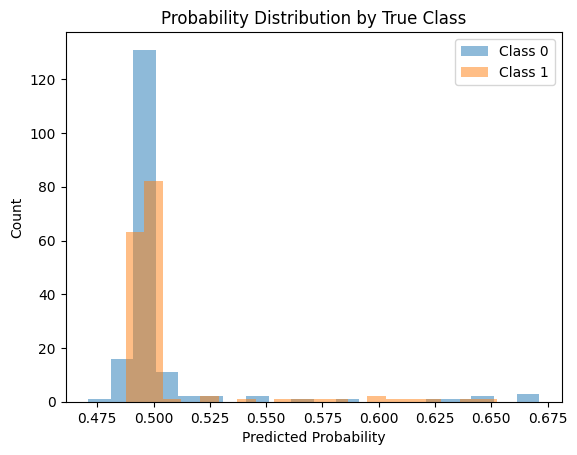

In [60]:
# Probability Distribution
plt.hist(test_probs[y_test_seq==0], bins=20, alpha=0.5, label='Class 0')
plt.hist(test_probs[y_test_seq==1], bins=20, alpha=0.5, label='Class 1')
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.title("Probability Distribution by True Class")

Text(0.5, 1.0, 'Precision-Recall Tradeoff')

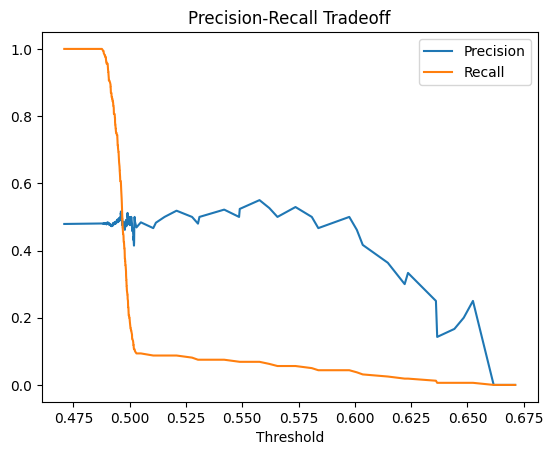

In [61]:
# Threshold Tuning

precision, recall, thresholds = precision_recall_curve(y_test_seq, test_probs)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision-Recall Tradeoff")

### All Pairs

#### GARCH GRU Pipeline

In [62]:
class GARCHGRUPipeline:
    def __init__(self, pivoted_data, significant_pairs_df):
        self.pivoted_data = pivoted_data
        self.significant_pairs = significant_pairs_df
        self.results_df = []

    def calculate_spread(self, row):
        spread = (self.pivoted_data[row['Symbol_1']] - row['beta'] * self.pivoted_data[row['Symbol_2']] - row['mu']).dropna()
        return spread


    def fit_garch(self, spread):
        returns = spread.diff().dropna()
        scaling_factor = 1 / returns.std()
        scaled_returns = returns * scaling_factor
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = arch_model(scaled_returns, vol='Garch', p=1, q=1)
            results = model.fit(update_freq=5, disp='off')
        conditional_vol = results.conditional_volatility / scaling_factor
        standardized_resid = results.resid / results.conditional_volatility
        return results, conditional_vol, standardized_resid

    def perform_diagnostics(self, standardized_resid):
        lb_test = acorr_ljungbox(standardized_resid, lags=10, return_df=True)
        arch_test = het_arch(standardized_resid, nlags=5)
        return lb_test, arch_test

    def add_features(self, spread, garch_results):
        df = spread.to_frame(name='spread')
        for lag in range(1, 6):
            df[f'lag_{lag}'] = df['spread'].shift(lag)
        df.dropna(inplace=True)

        garch_df = pd.DataFrame({
            'garch_vol': garch_results['vol'],
            'garch_resid': garch_results['resid']
        }, index=garch_results['index'])
        df = df.join(garch_df, how='inner')

        df['MA_5'] = df['spread'].rolling(5).mean()
        df['MA_20'] = df['spread'].rolling(20).mean()

        delta = df['spread'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(14).mean()
        avg_loss = loss.rolling(14).mean()
        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))
        df.dropna(inplace=True)

        return df

    def prepare_data(self, df):
        df['target'] = ((df['spread'].shift(-1) - df['spread']) * df['spread'] < 0).astype(int)
        features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
                    'garch_vol', 'garch_resid', 'MA_5', 'MA_20', 'RSI']
        X = df[features].iloc[:-1]
        y = df['target'].iloc[:-1]
        return X, y

    def create_sequences(self, data, seq_length=20):
        return np.array([data[i:i + seq_length] for i in range(len(data) - seq_length)])

    def train_gru_model(self, X_train_seq, y_train_seq):
        model = Sequential([
            GRU(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
            Dropout(0.3),
            GRU(64),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_train_seq, y_train_seq, validation_split=0.15,
                  epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)
        return model

    def evaluate_predictions_with_threshold(self, y_true, y_probs):
        precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_idx = np.argmax(f1)
        best_threshold = thresholds[best_idx]
        y_pred = (y_probs >= best_threshold).astype(int)
        return {
            "best_threshold": best_threshold,
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_score": f1_score(y_true, y_pred, zero_division=0),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "confusion_matrix": confusion_matrix(y_true, y_pred).tolist()
        }

    def evaluate_model(self, model, X_train_seq, y_train_seq, X_test_seq, y_test_seq):
        def evaluate(y_true, y_pred):
            try:
                return {
                    'accuracy': accuracy_score(y_true, y_pred),
                    'f1': f1_score(y_true, y_pred, zero_division=0),
                    'precision': precision_score(y_true, y_pred, zero_division=0),
                    'recall': recall_score(y_true, y_pred, zero_division=0)
                }
            except Exception as e:
                print(f"Evaluation error: {e}")
                return {
                    'accuracy': 0.0,
                    'f1': 0.0,
                    'precision': 0.0,
                    'recall': 0.0
                }
    
        train_probs = model.predict(X_train_seq, verbose=0)
        test_probs = model.predict(X_test_seq, verbose=0)
        train_pred = (train_probs > 0.5).astype(int).flatten()
        test_pred = (test_probs > 0.5).astype(int).flatten()
    
        return {
            'train': evaluate(y_train_seq, train_pred),
            'test': evaluate(y_test_seq, test_pred)
        }

    def run_pipeline(self):
        for i, row in tqdm(self.significant_pairs.iterrows(), total=len(self.significant_pairs), 
                           desc="Processing All Pairs", unit='row'):
            try:
                spread = self.calculate_spread(row)
                garch_fit, vol, resid = self.fit_garch(spread)
                garch_results = {'vol': vol, 'resid': resid, 'index': spread.index}
    
                df = self.add_features(spread, garch_results)
                X, y = self.prepare_data(df)
    
                split_idx = int(len(X) * 0.8)
                X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
                y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
                X_train_seq = self.create_sequences(X_train.values)
                X_test_seq = self.create_sequences(X_test.values)
                y_train_seq = y_train.iloc[20:].values
                y_test_seq = y_test.iloc[20:].values
    
                model = self.train_gru_model(X_train_seq, y_train_seq)
                metrics = self.evaluate_model(model, X_train_seq, y_train_seq, X_test_seq, y_test_seq)
    
                self.results_df.append({
                    'Symbol_1': row['Symbol_1'],
                    'Symbol_2': row['Symbol_2'],
                    'train_accuracy': metrics['train']['accuracy'],
                    'train_precision': metrics['train']['precision'],
                    'train_recall': metrics['train']['recall'],
                    'train_f1': metrics['train']['f1'],
                    'test_accuracy': metrics['test']['accuracy'],
                    'test_precision': metrics['test']['precision'],
                    'test_recall': metrics['test']['recall'],
                    'test_f1': metrics['test']['f1'],
                })
    
            except Exception as e:
                print(f"Error processing pair {row['Symbol_1']} - {row['Symbol_2']}: {e}")
    
        # return pd.DataFrame(self.results_df)
        results = pd.DataFrame(self.results_df)
        results.sort_values(by='test_f1', ascending=False, inplace=True)
        return results

In [63]:
pipeline = GARCHGRUPipeline(pivoted_data, significant_pairs)
garch_results_df = pipeline.run_pipeline()

Processing All Pairs:   0%|          | 0/267 [00:00<?, ?row/s]

C:\Users\nisha\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\nisha\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


| Metric     | Use Case                      | Why It Matters                                      |
|------------|-------------------------------|-----------------------------------------------------|
| F1-Score   | Imbalanced classes            | Balances precision and recall.                      |
| AUC-ROC    | Threshold-agnostic evaluation | Tests the separability of reverting/non-reverting states. |
| Accuracy   | Balanced classes              | Simple but often misleading in finance.           |
| Precision  | Reduce false positives        | Helps avoid unprofitable trades.                   |

Best Choice: F1-Score (if class balance is unknown) or AUC-ROC (for nuanced thresholding).

In [64]:
garch_results_df.head(5)

,Symbol_1,Symbol_2,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1
40,BSY,XRX,0.517192,0.517192,1.000000,0.681775,0.586826,0.586826,1.000000,0.739623
47,BDC,MSI,0.533668,0.533668,1.000000,0.695936,0.571856,0.571856,1.000000,0.727619
138,DGII,KEYS,0.508596,0.508596,1.000000,0.674264,0.568862,0.568862,1.000000,0.725191
74,INFA,PLAB,0.537249,0.537249,1.000000,0.698975,0.565868,0.567568,0.994737,0.722753
172,SANM,TWLO,0.536533,0.536023,0.995984,0.696956,0.562874,0.561562,1.000000,0.719231


### Top Pair

#### Hyper Parameter Tuning

In [65]:
# Step 1: Calculate Spread

pair = garch_results_df.iloc[0]  # first pair
symbol1 = pair['Symbol_1']
symbol2 = pair['Symbol_2']

significant_pairs[
    (significant_pairs['Symbol_1'] == pair['Symbol_1']) &
    (significant_pairs['Symbol_2'] == pair['Symbol_2'])
]

beta =  significant_pairs['beta'][
    (significant_pairs['Symbol_1'] == pair['Symbol_1']) &
    (significant_pairs['Symbol_2'] == pair['Symbol_2'])
].values

mu =  significant_pairs['mu'][
    (significant_pairs['Symbol_1'] == pair['Symbol_1']) &
    (significant_pairs['Symbol_2'] == pair['Symbol_2'])
].values

In [66]:
# Calculate spread
spread = (pivoted_data[symbol1] - beta * pivoted_data[symbol2] - mu).dropna()

In [67]:
# Step 2: Create Lagged Spread Features
if isinstance(spread, pd.Series):
    spread = spread.to_frame(name='spread')

# Now create lagged features
for lag in range(1, 6):
    spread[f'lag_{lag}'] = spread['spread'].shift(lag)

# Drop rows with NaN (from lagging)
spread = spread.dropna()

In [68]:
# Verify the result
spread.head(10)

,spread,lag_1,lag_2,lag_3,lag_4,lag_5
timestamp,,,,,,
2024-04-02 08:30:00-05:00,-0.080368,-0.078822,-0.081798,-0.075146,-0.075524,-0.074018
2024-04-02 09:30:00-05:00,-0.075322,-0.080368,-0.078822,-0.081798,-0.075146,-0.075524
2024-04-02 10:30:00-05:00,-0.075067,-0.075322,-0.080368,-0.078822,-0.081798,-0.075146
2024-04-02 11:30:00-05:00,-0.077239,-0.075067,-0.075322,-0.080368,-0.078822,-0.081798
2024-04-02 12:30:00-05:00,-0.071892,-0.077239,-0.075067,-0.075322,-0.080368,-0.078822
2024-04-02 13:30:00-05:00,-0.078442,-0.071892,-0.077239,-0.075067,-0.075322,-0.080368
2024-04-02 14:30:00-05:00,-0.083312,-0.078442,-0.071892,-0.077239,-0.075067,-0.075322
2024-04-03 08:30:00-05:00,-0.085651,-0.083312,-0.078442,-0.071892,-0.077239,-0.075067
2024-04-03 09:30:00-05:00,-0.077263,-0.085651,-0.083312,-0.078442,-0.071892,-0.077239


In [69]:
# Step 3: Add GARCH Features
garch_vol = results.conditional_volatility
garch_resid = results.resid / garch_vol

# 4. Align with original spread data
# First create a temporary DataFrame with GARCH outputs
garch_features = pd.DataFrame({
    'garch_vol': garch_vol,
    'garch_resid': garch_resid
}, index=scaled_returns.index)  # Important: use scaled_returns' index

# 5. Merge with original spread data
spread = spread.join(garch_features, how='inner')  # Only keep dates with GARCH values

In [70]:
# Step 4: Add Technical Indicators

# Moving Averages
spread['MA_5'] = spread['spread'].rolling(5).mean()
spread['MA_20'] = spread['spread'].rolling(20).mean()

# RSI (14-day)
delta = spread['spread'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
spread['RSI'] = 100 - (100 / (1 + rs))

# Drop NaN from rolling calculations
spread = spread.dropna()

In [71]:
# Verify the result
spread.head(5)

,spread,lag_1,lag_2,lag_3,lag_4,lag_5,garch_vol,garch_resid,MA_5,MA_20,RSI
2024-04-04 13:30:00-05:00,-0.099032,-0.085762,-0.071903,-0.070696,-0.070427,-0.073132,0.891730,-1.289143,-0.079564,-0.081214,39.761163
2024-04-04 14:30:00-05:00,-0.102234,-0.099032,-0.085762,-0.071903,-0.070696,-0.070427,0.897607,-0.310421,-0.085925,-0.082308,40.431692
2024-04-05 08:30:00-05:00,-0.100183,-0.102234,-0.099032,-0.085762,-0.071903,-0.070696,0.896837,1.768386,-0.091823,-0.083551,42.630044
2024-04-05 09:30:00-05:00,-0.091600,-0.100183,-0.102234,-0.099032,-0.085762,-0.071903,0.908598,-0.892721,-0.095762,-0.084377,42.743535
2024-04-05 10:30:00-05:00,-0.090632,-0.091600,-0.100183,-0.102234,-0.099032,-0.085762,0.910394,-0.265016,-0.096736,-0.085047,43.977646


In [72]:
future_spread = spread['spread'].shift(-1)
current_spread = spread['spread']
spread['target'] = ((future_spread - current_spread) * current_spread < 0).astype(int)

In [73]:
# Select features and target
features = [
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
    'garch_vol', 'garch_resid',
    'MA_5', 'MA_20', 'RSI'
]

X = spread[features]
y = spread['target']

# Drop last row (where target is NaN)
X = X.iloc[:-1]
y = y.iloc[:-1]

In [74]:
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [75]:
# Assuming X_train, X_test, y_train, y_test are already loaded
print("Class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))

# Verify shapes
print(f"\nShapes:\nX_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Class distribution:
target
1    0.519068
0    0.480932
Name: proportion, dtype: float64

Shapes:
X_train: (1416, 10), y_train: (1416,)
X_test: (354, 10), y_test: (354,)


In [76]:
def create_sequences(data, targets, seq_length):
    """Create time-series sequences with aligned features and labels"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(targets.iloc[i+seq_length])
    return np.array(X), np.array(y)

# Test the function
test_seq, test_labels = create_sequences(X_train, y_train, 10)
print(f"Sample sequence shape: {test_seq.shape}")  # (n_samples, seq_length, n_features)

Sample sequence shape: (1406, 10, 10)


In [77]:
def get_class_weights(y, strategy='balanced'):
    if strategy == 'balanced':
        classes = np.unique(y)
        weights = compute_class_weight('balanced', classes=classes, y=y)
        # return {i: w for i, w in enumerate(weights)}
        return {cls: w for cls, w in zip(classes, weights)}
    return None

In [78]:
def build_model(gru_units=128, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        GRU(gru_units, input_shape=(None, X_train.shape[1])),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [79]:
param_grid = {
    'sequence_length': [10, 20, 30],
    'gru_units': [64, 128],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32, 64],
    'class_weight': [None, 'balanced']
}

n_iter = 8  # Number of combinations to try
# param_list = [dict(zip(param_grid.keys(), vals)) 
#             for vals in zip(*[random.choices(v, k=n_iter) for v in param_grid.values()])]

param_list = [dict(zip(param_grid.keys(), [random.choice(param_grid[k]) for k in param_grid])) for _ in range(n_iter)]


In [80]:
results = []
val_split = 0.15 / 0.8  # 15% validation of original data

for params in tqdm(param_list, desc="Hyperparameter Tuning"):
    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, params['sequence_length'])
    
    # Handle class weights
    class_weight = get_class_weights(y_train_seq) if params['class_weight'] == 'balanced' else None
    
    # Build and train model
    model = build_model(
        gru_units=params['gru_units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )
    
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_split=val_split,
        epochs=50,
        batch_size=params['batch_size'],
        class_weight=class_weight,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )
    
    # Store results
    best_epoch = np.argmin(history.history['val_loss'])
    results.append({
        **params,
        'best_val_auc': history.history['val_auc'][best_epoch],
        'best_val_loss': history.history['val_loss'][best_epoch]
    })

Hyperparameter Tuning:   0%|          | 0/8 [00:00<?, ?it/s]

In [81]:
results_df = pd.DataFrame(results).sort_values('best_val_auc', ascending=False)
print("Top Configurations:")
print(results_df.head(3)[['sequence_length', 'gru_units', 'dropout_rate', 
                        'learning_rate', 'best_val_auc']])

Top Configurations:
   sequence_length  gru_units  dropout_rate  learning_rate  best_val_auc
3               10        128           0.3         0.0005      0.529545
2               30        128           0.3         0.0010      0.497594
4               30         64           0.2         0.0005      0.476121


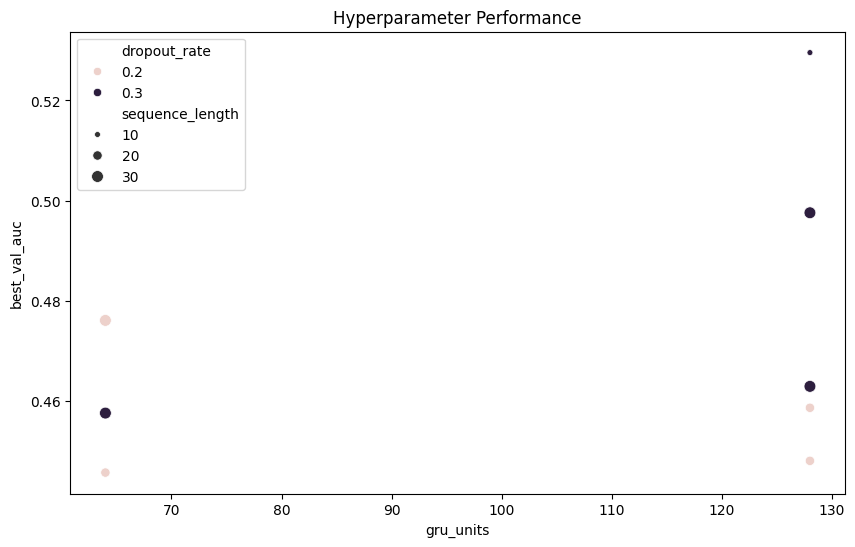

In [82]:
# Visualize
plt.figure(figsize=(10,6))
sns.scatterplot(data=results_df, x='gru_units', y='best_val_auc',
               hue='dropout_rate', size='sequence_length')
plt.title("Hyperparameter Performance")
plt.show()

In [83]:
best_params = results_df.iloc[0]

# Create sequences with optimal length
X_train_seq, y_train_seq = create_sequences(X_train, y_train, best_params['sequence_length'])
X_test_seq, y_test_seq = create_sequences(X_test, y_test, best_params['sequence_length'])

# Build final model
final_model = build_model(
    gru_units=best_params['gru_units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

# Train with early stopping
history = final_model.fit(
    X_train_seq, y_train_seq,
    batch_size=best_params['batch_size'],
    epochs=100,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    class_weight=get_class_weights(y_train_seq) if best_params['class_weight'] else None
)

Epoch 1/100
22/22 [==============================] - 1s 24ms/step - loss: 0.7661 - accuracy: 0.5028 - auc: 0.4901 - val_loss: 0.6997 - val_accuracy: 0.4448 - val_auc: 0.4373
Epoch 2/100
22/22 [==============================] - 0s 10ms/step - loss: 0.7412 - accuracy: 0.5014 - auc: 0.5114 - val_loss: 0.6925 - val_accuracy: 0.5087 - val_auc: 0.4277
Epoch 3/100
22/22 [==============================] - 0s 9ms/step - loss: 0.7467 - accuracy: 0.5078 - auc: 0.4997 - val_loss: 0.6939 - val_accuracy: 0.5058 - val_auc: 0.4345
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.7474 - accuracy: 0.4879 - auc: 0.4885 - val_loss: 0.6901 - val_accuracy: 0.5785 - val_auc: 0.4325
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.7436 - accuracy: 0.5092 - auc: 0.5003 - val_loss: 0.6929 - val_accuracy: 0.5174 - val_auc: 0.4449
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 0.7322 - accuracy: 0.5100 - auc: 0.5107 - val_loss: 0.6910 -

In [84]:
# Predictions
y_pred_proba = final_model.predict(X_test_seq)
y_pred = (y_pred_proba > 0.5).astype(int)

# Metrics
print(classification_report(y_test_seq, y_pred))

11/11 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.18      0.01      0.03       141
           1       0.58      0.96      0.72       203

    accuracy                           0.57       344
   macro avg       0.38      0.48      0.38       344
weighted avg       0.42      0.57      0.44       344



In [85]:
print("\nConfusion Matrix:")
print(pd.crosstab(y_test_seq, y_pred.ravel(), 
                 rownames=['Actual'], 
                 colnames=['Predicted']))


Confusion Matrix:
Predicted  0    1
Actual           
0          2  139
1          9  194


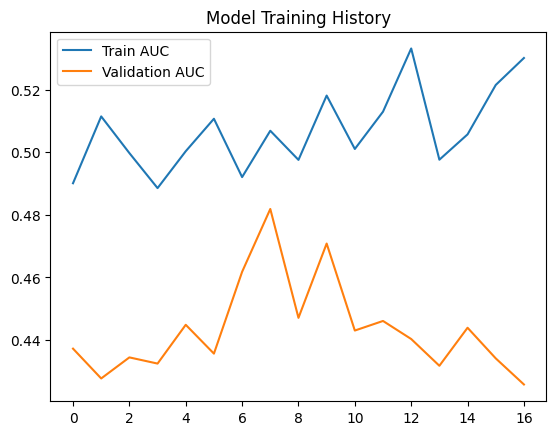

In [86]:
# Plot training history
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model Training History')
plt.legend()
plt.show()

In [87]:
precisions, recalls, thresholds = precision_recall_curve(y_test_seq, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"Max F1-Score: {f1_scores[optimal_idx]:.3f}")

Optimal Threshold: 0.696
Max F1-Score: nan


C:\Users\nisha\AppData\Local\Temp\ipykernel_22976\4193741418.py:2: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


#### Using Optuna

In [88]:
# Define the Optuna objective function
def objective(trial):
    # Sample hyperparameters
    sequence_length = trial.suggest_categorical("sequence_length", [10, 20, 30])
    gru_units = trial.suggest_categorical("gru_units", [64, 128])
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.3)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    use_class_weight = trial.suggest_categorical("class_weight", [True, False])
    
    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
    
    # Determine validation set size
    val_size = int(val_split * len(X_train_seq))
    X_train_final = X_train_seq[:-val_size]
    y_train_final = y_train_seq[:-val_size]
    X_val = X_train_seq[-val_size:]
    y_val = y_train_seq[-val_size:]
    
    # Compute class weights if needed
    class_weight = get_class_weights(y_train_final) if use_class_weight else None

    # Build and compile model
    model = build_model(
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )
    
    # Train model
    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        class_weight=class_weight,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0  # Suppress training logs
    )
    
    # Predict on validation data
    y_val_pred_proba = model.predict(X_val, verbose=0).ravel()
    
    # Compute F1 score using best threshold from precision-recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_f1 = np.max(f1_scores)

    return best_f1

In [89]:
# Progress bar callback
class TQDMCallback:
    def __init__(self, total):
        self.pbar = tqdm(total=total)

    def __call__(self, study, trial):
        self.pbar.update(1)

    def close(self):
        self.pbar.close()

# Set number of trials
n_trials = 100
tqdm_cb = TQDMCallback(total=n_trials)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials, callbacks=[tqdm_cb], show_progress_bar=False)

# Close progress bar
tqdm_cb.close()

  0%|          | 0/100 [00:00<?, ?it/s]

In [90]:
print("Best trial:")
print(study.best_trial)

Best trial:
FrozenTrial(number=39, state=TrialState.COMPLETE, values=[0.743276278923488], datetime_start=datetime.datetime(2025, 5, 17, 9, 56, 38, 990222), datetime_complete=datetime.datetime(2025, 5, 17, 9, 56, 42, 467111), params={'sequence_length': 10, 'gru_units': 128, 'dropout_rate': 0.21330251747702916, 'learning_rate': 0.0003702445452201595, 'batch_size': 32, 'class_weight': True}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'sequence_length': CategoricalDistribution(choices=(10, 20, 30)), 'gru_units': CategoricalDistribution(choices=(64, 128)), 'dropout_rate': FloatDistribution(high=0.3, log=False, low=0.2, step=None), 'learning_rate': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'batch_size': CategoricalDistribution(choices=(32, 64)), 'class_weight': CategoricalDistribution(choices=(True, False))}, trial_id=39, value=None)


In [91]:
print("Best Trial:")
print(f"Best F1 Score: {study.best_trial.value:.4f}")
print("Best Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

Best Trial:
Best F1 Score: 0.7433
Best Hyperparameters:
  sequence_length: 10
  gru_units: 128
  dropout_rate: 0.21330251747702916
  learning_rate: 0.0003702445452201595
  batch_size: 32
  class_weight: True


In [92]:
# Get best trial and its parameters
best_params = study.best_trial.params

# Re-create sequences with best sequence_length
best_seq_len = best_params["sequence_length"]
X_train_seq, y_train_seq = create_sequences(X_train, y_train, best_seq_len)

# Optionally recompute validation split
val_size = int(val_split * len(X_train_seq))
X_train_final = X_train_seq[:-val_size]
y_train_final = y_train_seq[:-val_size]
X_val = X_train_seq[-val_size:]
y_val = y_train_seq[-val_size:]

# Recompute class weights if needed
use_class_weight = best_params["class_weight"]
class_weight = get_class_weights(y_train_final) if use_class_weight else None

# Build final model with best params
final_model = build_model(
    gru_units=best_params["gru_units"],
    dropout_rate=best_params["dropout_rate"],
    learning_rate=best_params["learning_rate"]
)

# Train final model
final_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=best_params["batch_size"],
    class_weight=class_weight,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1  # Set to 0 to suppress output
)

Epoch 1/50
36/36 [==============================] - 2s 17ms/step - loss: 0.7540 - accuracy: 0.5389 - auc: 0.5415 - val_loss: 0.6973 - val_accuracy: 0.4183 - val_auc: 0.5403
Epoch 2/50
36/36 [==============================] - 0s 7ms/step - loss: 0.7361 - accuracy: 0.4961 - auc: 0.4906 - val_loss: 0.7014 - val_accuracy: 0.4259 - val_auc: 0.5151
Epoch 3/50
36/36 [==============================] - 0s 7ms/step - loss: 0.7460 - accuracy: 0.4847 - auc: 0.4759 - val_loss: 0.6850 - val_accuracy: 0.5856 - val_auc: 0.5164
Epoch 4/50
36/36 [==============================] - 0s 7ms/step - loss: 0.7244 - accuracy: 0.5118 - auc: 0.5171 - val_loss: 0.6855 - val_accuracy: 0.5779 - val_auc: 0.5221
Epoch 5/50
36/36 [==============================] - 0s 6ms/step - loss: 0.7329 - accuracy: 0.4943 - auc: 0.5003 - val_loss: 0.7037 - val_accuracy: 0.4335 - val_auc: 0.5251
Epoch 6/50
36/36 [==============================] - 0s 6ms/step - loss: 0.7265 - accuracy: 0.5092 - auc: 0.5074 - val_loss: 0.7069 - val_ac

In [93]:
#inal_model.save('gru_model_full')

In [94]:
# Save as a single HDF5 file
final_model.save('gru_model.h5')

In [95]:
# View keys: e.g., ['loss', 'val_loss', 'accuracy', 'val_accuracy']
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


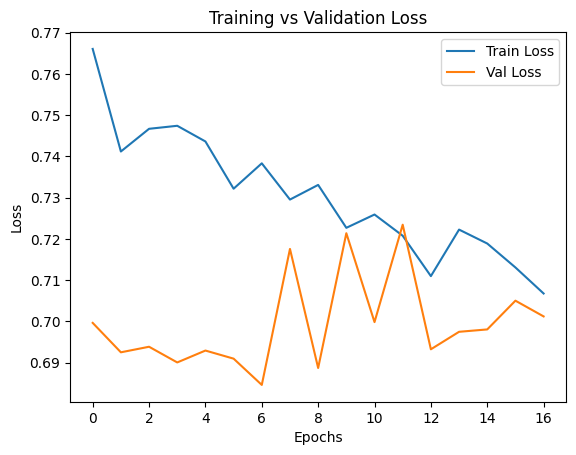

In [96]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Backtesting

## Simple Strategy

In [97]:
# Step 1: Get pair info
pair = garch_results_df.iloc[0]
symbol1 = pair['Symbol_1']
symbol2 = pair['Symbol_2']

# Step 2: Get beta and mu from significant_pairs
mask = (
    (significant_pairs['Symbol_1'] == symbol1) &
    (significant_pairs['Symbol_2'] == symbol2)
)
beta = significant_pairs.loc[mask, 'beta'].values[0]
mu = significant_pairs.loc[mask, 'mu'].values[0]

In [98]:
pair

Symbol_1                BSY
Symbol_2                XRX
train_accuracy     0.517192
train_precision    0.517192
train_recall            1.0
train_f1           0.681775
test_accuracy      0.586826
test_precision     0.586826
test_recall             1.0
test_f1            0.739623
Name: 40, dtype: object

In [99]:
print(f'beta = {beta} \n mu = {mu}')

beta = 0.2037723742929534 
 mu = 3.4115164600223054


In [100]:
# Fetch data from database
query = f"""
SELECT a.timestamp, a.open, a.high, a.low, a.close, a.volume
FROM yahoo_data_min a
WHERE a.symbol = '{symbol1}';
"""

gru_data1_df = db.fetch_data(query)

# Convert to proper datetime index
gru_data1_df = (
    gru_data1_df
    .set_index('timestamp')
    .pipe(lambda df: df.set_index(
        pd.to_datetime(df.index, utc=True)
        .tz_localize(None)  # Remove timezone for Backtrader
    ))
)

# Quality checks
assert gru_data1_df.index.tz is None, "Index still has timezone info"
assert not gru_data1_df.isnull().values.any(), "Data contains NaN values"

In [101]:
gru_data1_df.to_pickle('gru_data1_df.pkl')

In [102]:
# Fetch data from database
query = f"""
SELECT a.timestamp, a.open, a.high, a.low, a.close, a.volume
FROM yahoo_data_min a
WHERE a.symbol = '{symbol2}';
"""

gru_data2_df = db.fetch_data(query)

# Convert to proper datetime index
gru_data2_df = (
    gru_data2_df
    .set_index('timestamp')
    .pipe(lambda df: df.set_index(
        pd.to_datetime(df.index, utc=True)
        .tz_localize(None)  # Remove timezone for Backtrader
    ))
)

# Quality checks
assert gru_data2_df.index.tz is None, "Index still has timezone info"
assert not gru_data2_df.isnull().values.any(), "Data contains NaN values"

In [103]:
gru_data2_df.to_pickle('gru_data2_df.pkl')

In [104]:
from itertools import product
import backtrader as bt
class SpreadZScore(bt.Indicator):
    lines = ('spread', 'zscore',)
    params = (('window', 7),)
    
    def __init__(self):
        self.addminperiod(self.p.window)
        
    def next(self):
        price1 = np.array(self.data0.close.get(size=self.p.window))
        price2 = np.array(self.data1.close.get(size=self.p.window))
        
        X = sm.add_constant(price2)
        model = sm.OLS(price1, X).fit()
        beta = model.params[1]
        
        spread = price1[-1] - (beta * price2[-1])
        self.lines.spread[0] = spread
        
        if len(self.lines.spread) >= self.p.window:
            spread_window = np.array(self.lines.spread.get(size=self.p.window))
            mean = np.mean(spread_window)
            std = np.std(spread_window)
            self.lines.zscore[0] = (spread - mean) / std if std > 0 else 0

class PairsTradingStrategy(bt.Strategy):
    params = (
        ('window', 7),
        ('entry_threshold', 1.5),
        ('exit_threshold', 0.5),
        ('stop_loss', 2.5),
        ('take_profit', 2.0),
        ('order_pct', 0.95),
        ('printlog', False)
    )

    def __init__(self):
        self.spread_zscore = SpreadZScore(self.data0, self.data1, window=self.p.window)
        self.trade_count = 0
        self.in_position = False

    def next(self):
        if len(self.data0) < self.p.window or len(self.data1) < self.p.window:
            return
            
        zscore = self.spread_zscore.zscore[0]
        
        if not self.in_position:
            if zscore > self.p.entry_threshold:
                size0 = self.broker.getcash() * self.p.order_pct / self.data0.close[0]
                size1 = (size0 * self.data0.close[0]) / self.data1.close[0]
                self.sell(data=self.data0, size=size0)
                self.buy(data=self.data1, size=size1)
                self.in_position = True
                self.trade_direction = -1
                
            elif zscore < -self.p.entry_threshold:
                size0 = self.broker.getcash() * self.p.order_pct / self.data0.close[0]
                size1 = (size0 * self.data0.close[0]) / self.data1.close[0]
                self.buy(data=self.data0, size=size0)
                self.sell(data=self.data1, size=size1)
                self.in_position = True
                self.trade_direction = 1
                
        else:
            if ((self.trade_direction == 1 and zscore >= -self.p.exit_threshold) or
                (self.trade_direction == -1 and zscore <= self.p.exit_threshold) or
                abs(zscore) >= self.p.stop_loss):
                self.close(data=self.data0)
                self.close(data=self.data1)
                self.in_position = False

def prepare_data(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.set_index(pd.to_datetime(df.index))
    return df[['open', 'high', 'low', 'close', 'volume']].ffill()

def optimize_strategy(symbol1, symbol2, df1, df2, initial_cash=100000):
    param_ranges = {
        'window': [5, 7, 14, 21],
        'entry_threshold': [1.0, 1.5, 2.0],
        'exit_threshold': [0.25, 0.5, 0.75],
        'order_pct': [0.8, 0.85, 0.9, 0.95]
    }
    
    results = []
    best_sharpe = -np.inf
    best_params = None
    
    for i, params in enumerate(product(*param_ranges.values())):
        window, entry_thresh, exit_thresh, order_pct = params
        
        cerebro = bt.Cerebro(stdstats=False)  # Disable default observers for optimization
        data1 = bt.feeds.PandasData(dataname=prepare_data(df1))
        data2 = bt.feeds.PandasData(dataname=prepare_data(df2))
        cerebro.adddata(data1, name=symbol1)
        cerebro.adddata(data2, name=symbol2)
        
        cerebro.addstrategy(
            PairsTradingStrategy,
            window=window,
            entry_threshold=entry_thresh,
            exit_threshold=exit_thresh,
            order_pct=order_pct,
            printlog=False
        )
        
        cerebro.broker.setcash(initial_cash)
        cerebro.broker.setcommission(0.001)
        
        # Add analyzers with proper configuration
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', timeframe=bt.TimeFrame.Days)
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
        
        try:
            strat = cerebro.run()[0]
            sharpe_analysis = strat.analyzers.sharpe.get_analysis()
            sharpe = sharpe_analysis['sharperatio'] if 'sharperatio' in sharpe_analysis else None
            dd_analysis = strat.analyzers.drawdown.get_analysis()
            
            if sharpe is None:
                print(f"Test {i+1}: No valid Sharpe ratio calculated - likely no trades")
                continue
                
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_params = params
                
            results.append({
                'window': window,
                'entry': entry_thresh,
                'exit': exit_thresh,
                'size': order_pct,
                'sharpe': sharpe,
                'drawdown': dd_analysis['max']['drawdown'],
                'final_value': cerebro.broker.getvalue(),
                'trades': strat.analyzers.trades.get_analysis().total.closed if hasattr(strat, 'analyzers') and hasattr(strat.analyzers, 'trades') else 0
            })
            
            #print(f"Test {i+1}: Params {params} | Sharpe: {sharpe:.2f} | Trades: {results[-1]['trades']}")
            print(f"Test {i+1}: Params {params} | Sharpe: {sharpe:.2f}")
            
        except Exception as e:
            print(f"Test {i+1} failed with params {params}: {str(e)}")
            continue

    if not results:
        raise ValueError("No valid backtests completed - check your data and parameters")
    
    results_df = pd.DataFrame(results).sort_values('sharpe', ascending=False)
    return results_df, best_params

def run_best_strategy(symbol1, symbol2, df1, df2, best_params, initial_cash=100000):
    cerebro = bt.Cerebro()
    data1 = bt.feeds.PandasData(dataname=prepare_data(df1))
    data2 = bt.feeds.PandasData(dataname=prepare_data(df2))
    cerebro.adddata(data1, name=symbol1)
    cerebro.adddata(data2, name=symbol2)
    
    cerebro.addstrategy(
        PairsTradingStrategy,
        window=best_params[0],
        entry_threshold=best_params[1],
        exit_threshold=best_params[2],
        order_pct=best_params[3],
        printlog=True
    )
    
    cerebro.broker.setcash(initial_cash)
    cerebro.broker.setcommission(0.001)
    
    # Add analyzers with proper configuration
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    
    print('\n=== Running with Best Parameters ===')
    print(f"Window: {best_params[0]}")
    print(f"Entry Threshold: {best_params[1]}")
    print(f"Exit Threshold: {best_params[2]}")
    print(f"Order Percentage: {best_params[3]}")
    
    results = cerebro.run()
    strat = results[0]
    
    print('\n=== Final Results ===')
    print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")
    
    # Safe Sharpe ratio reporting
    sharpe_analysis = strat.analyzers.sharpe.get_analysis()
    sharpe = sharpe_analysis.get('sharperatio', None)
    print(f"Sharpe Ratio: {sharpe:.2f}" if sharpe is not None else "Sharpe Ratio: N/A (no trades)")
    
    # Safe drawdown reporting
    dd_analysis = strat.analyzers.drawdown.get_analysis()
    max_dd = dd_analysis.get('max', {}).get('drawdown', None)
    print(f"Max Drawdown: {max_dd:.2f}%" if max_dd is not None else "Max Drawdown: N/A")
    
    # Safe trade analysis
    try:
        trade_analysis = strat.analyzers.trades.get_analysis()
        total_trades = trade_analysis.total.closed
        won_trades = trade_analysis.won.total
        win_rate = (won_trades / total_trades * 100) if total_trades > 0 else 0
        
        print(f"\nTrade Analysis:")
        print(f"Total Trades: {total_trades}")
        print(f"Winning Trades: {won_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
    except Exception as e:
        print("\nTrade Analysis: Failed -", str(e))
        
    
    # Safe returns reporting
    try:
        returns_analysis = strat.analyzers.returns.get_analysis()
        rtot = returns_analysis.get('rtot', None)
        print(f"Total Return: {rtot:.2%}" if rtot is not None else "Total Return: N/A")

        # Plot and save the figure
        cerebro.plot(style='candlestick', volume=False)

        figs = cerebro.plot(style='candlestick', volume=False)
        for fig in figs:
            fig[0].set_size_inches(20, 10) 
            fig[0].savefig('cerebro_plot_gru.png', dpi=600)
            plt.show()
        print("Plot saved as cerebro_plot.png")

    except Exception as e:
        print("Returns Analysis: Failed -", str(e))


if __name__ == '__main__':
    # Load your data
    df1 = gru_data1_df
    df2 = gru_data2_df
    
    # Run optimization
    results_df, best_params = optimize_strategy(symbol1, symbol2, df1, df2)
    
    # Display top 5 results
    print("\nTop 5 Parameter Sets:")
    print(results_df.head(5))
    
    # Run with best parameters
    run_best_strategy(symbol1, symbol2, df1, df2, best_params)

Test 1: Params (5, 1.0, 0.25, 0.8) | Sharpe: -0.21
Test 2: Params (5, 1.0, 0.25, 0.85) | Sharpe: -0.21
Test 3: Params (5, 1.0, 0.25, 0.9) | Sharpe: -0.21
Test 4: Params (5, 1.0, 0.25, 0.95) | Sharpe: -0.17
Test 5: Params (5, 1.0, 0.5, 0.8) | Sharpe: -0.14
Test 6: Params (5, 1.0, 0.5, 0.85) | Sharpe: -0.14
Test 7: Params (5, 1.0, 0.5, 0.9) | Sharpe: -0.14
Test 8: Params (5, 1.0, 0.5, 0.95) | Sharpe: -0.11
Test 9: Params (5, 1.0, 0.75, 0.8) | Sharpe: -0.17
Test 10: Params (5, 1.0, 0.75, 0.85) | Sharpe: -0.17
Test 11: Params (5, 1.0, 0.75, 0.9) | Sharpe: -0.17
Test 12: Params (5, 1.0, 0.75, 0.95) | Sharpe: -0.18
Test 13: Params (5, 1.5, 0.25, 0.8) | Sharpe: -0.15
Test 14: Params (5, 1.5, 0.25, 0.85) | Sharpe: -0.15
Test 15: Params (5, 1.5, 0.25, 0.9) | Sharpe: -0.15
Test 16: Params (5, 1.5, 0.25, 0.95) | Sharpe: -0.18
Test 17: Params (5, 1.5, 0.5, 0.8) | Sharpe: -0.07
Test 18: Params (5, 1.5, 0.5, 0.85) | Sharpe: -0.07
Test 19: Params (5, 1.5, 0.5, 0.9) | Sharpe: -0.07
Test 20: Params (5,

<IPython.core.display.Javascript object>

Plot saved as cerebro_plot.png
